In [8]:
import nomic
import json
nomic.login("nk-2LSEn5FB5h04Dn0pFLuZ9jDw7ZaMbPpYPV88wbKKASc")
#- Scientific programming
import numpy as np
import pandas as pd
from tqdm import tqdm
import gc
import torch


#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#- Data
from nomic import AtlasDataset

#- Processing
from fuzzywuzzy import fuzz
from unidecode import unidecode
import re
import datetime

dataset = AtlasDataset('hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-10-08')

df = dataset.maps[0].data.df
embds = dataset.maps[0].embeddings.latent


/cis/home/tchen94/anaconda3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
2024-10-17 13:38:33.358 | INFO     | nomic.dataset:__init__:768 - Loading existing dataset `hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-10-08`.
2024-10-17 13:38:34.144 | WARNING  | nomic.data_operations:df:923 - Converting to pandas dataframe. This may materialize a large amount of data into memory.
2024-10-17 13:38:34.147 | INFO     | nomic.data_operations:_download_data:902 - Downloading data
100%|██████████| 129/129 [00:00<00:00, 1259.99it/s]
2024-10-17 13:38:35.280 | INFO     | nomic.data_operations:_load_data:872 - Loading data
100%|██████████| 129/129 [00:01<00:00, 71.76it/s] 
2024-10-17 13:38:41.135 | INFO     | nomic.data_operations:_download_latent:550 - Downloadi

In [54]:
df_congress = pd.read_csv('/cis/home/tchen94/my_documents/congressional-twin/experiments/tianyi/118-2024_h142.csv') ## this file should be already on my folder. 
congress_name_list_bill=df_congress['matched-name'].unique()
congress_name_list_bill = [name for name in congress_name_list_bill if pd.notnull(name)] ## remove nan
congress_name_list_bill 

In [10]:
df_congress.head()

,Unnamed: 0,person,state,district,vote,name,party,matched-name,twitter-handle,average-embd-global,average-embd-issue-specific,matched-state,matched-party
0,0,400004,AL,4,Yea,Rep. Robert Aderholt [R],Republican,"Aderholt, Robert",robert_aderholt,"[0.017503820146833146, 0.03896857670375279, -0...","[0.006040811538696289, 0.042439937591552734, -...",AL,R
1,1,400030,GA,2,Not Voting,Rep. Sanford Bishop [D],Democrat,"Bishop Jr., Sanford",sanfordbishop,"[0.018433302640914917, 0.049648284912109375, -...","[0.017269134521484375, 0.0095062255859375, -0....",GA,D
2,2,400033,OR,3,Yea,Rep. Earl Blumenauer [D],Democrat,NaN,NaN,NaN,NaN,NaN,NaN
3,3,400052,TX,26,Yea,Rep. Michael Burgess [R],Republican,"Burgess, Michael",michaelcburgess,"[0.021851594874400967, 0.05065598708904342, -0...","[0.02545155649599822, 0.08420595915421196, -0....",TX,R
4,4,400057,CA,41,Yea,Rep. Ken Calvert [R],Republican,"Calvert, Ken",kencalvert,"[0.018314135260879993, 0.05678512156009674, -0...","[0.020268772777758147, 0.06673792788856908, -0...",CA,R


In [11]:
## Bill is voted on 2017/July/28
congress_name_list= list(df['name'].unique())    
name_to_standardized_name = {}

t = pd.Timestamp(year=2017, month=7, day=28)

for name in congress_name_list:
    key = name
    name = name.lower()
    chunks = name.split(' ')[:2]
    if ',' in chunks[0]:
        name = chunks[1] + '_' + chunks[0][:-1]
    else:
        name = chunks[0] + '_' + chunks[1]
        
    name_to_standardized_name[key] = unidecode(name)
        
standardized_name_list = list(name_to_standardized_name.values())

n_congresspersons = len(congress_name_list)
all_text = {name: {'pre-t': [], 'post-t': []} for name in standardized_name_list}
all_embds = {name: {'pre-t': [], 'post-t': []} for name in standardized_name_list}

for i, embd in enumerate(tqdm(embds)):
    congress_name = name_to_standardized_name[df['name'][i]]
    posted_at = df['postedAt'][i]
    
    if posted_at > t:
        key='post-t'
    else:
        key='pre-t'
        
    all_text[congress_name][key].append(df['text'][i])
    all_embds[congress_name][key].append(embd)
    
for name in standardized_name_list:
    all_embds[name]['post-t'] = np.array(all_embds[name]['post-t'])
    all_embds[name]['pre-t'] = np.array(all_embds[name]['pre-t'])
    
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 3214913/3214913 [00:58<00:00, 55094.03it/s]


In [13]:
n_cps = 200 
cp_chosen = {}  

for name in congress_name_list_bill:
    #- only consider n_cps congresspersons
    if len(cp_chosen) >= n_cps:
        break
    stand_name= name_to_standardized_name[name]
    tweets = all_text[stand_name]['pre-t']
    #- only consider congresspersons with enough tweets after t
    if len(all_text[stand_name]['pre-t']) <10:
        continue
    
    cp_chosen[name]={'stand_name':stand_name,
                     'vote': df_congress[df_congress['matched-name'] == name]['vote'],
                     'party': df_congress[df_congress ['matched-name'] == name]['matched-party']}      

In [14]:
len(cp_chosen)

148

## The rest you don't quite need, still working on, not organized. 

In [2]:
import transformers
import torch

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="cuda:0",
)

from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

<All keys matched successfully>


In [15]:
## GPT-4o generation of questions for bill https://www.govtrack.us/congress/votes/115-2017/s179 

questions = [
    "What do you believe is the best approach to ensure universal access to affordable health care in the U.S.?",
    "How would you address the rising costs of prescription medications in a way that benefits both consumers and pharmaceutical companies?",
    "Do you support expanding Medicare or Medicaid, and why or why not?",
    "What role should the federal government play in regulating health insurance providers?",
    "How do you plan to balance the needs of health care providers with the financial constraints faced by patients, especially low-income families?",
    "What are your views on the role of private versus public health care options in the U.S. system?",
    "How do you plan to ensure that rural and underserved communities have access to quality health care services?",
    "What steps would you take to ensure that individuals with pre-existing conditions maintain access to affordable health care?",
    "Do you believe the U.S. should transition to a single-payer health care system? Why or why not?",
    "How would you address the ongoing debate about health care reform and its intersection with issues like mental health services, reproductive health, and senior care?"
]

In [16]:
## retirve the tweet that is most similar to the question
def get_rag_retrieved_tweet(name, question,pre_or_post):
    query_embed = embedding_model.encode(question)
    retrieve_pos = []
    dotprod = []
    for j in range(len(all_text[name][pre_or_post])):
        dotprod.append(np.sum(all_embds[name][pre_or_post][j] * query_embed))
    retrieve_pos.append(np.argmax(dotprod))
    rag_retrieved_tweet = all_text[name][pre_or_post][retrieve_pos[0]]
    rag_retrieved_tweet_embedding = all_embds[name][pre_or_post][retrieve_pos[0]]
    return rag_retrieved_tweet,rag_retrieved_tweet_embedding

In [23]:
list(cp_chosen.keys())[0]

'Danny Davis D-IL'

In [25]:
stand_name=cp_chosen[list(cp_chosen.keys())[0]]['stand_name']
get_rag_retrieved_tweet(stand_name, questions[1], 'pre-t')[0]

'RT @WaysMeansCmte: "Despite doomsday rhetoric, Obamacare markets are stabilizing" https://t.co/pFLo8QZa9e via @politico https://t.co/40Zq49…'

In [13]:
n=len(list(cp_chosen.keys()))
matrices = []

for k in range(n):
    matrix = np.zeros((len(questions),  768)  )
    stand_name = cp_chosen[list(cp_chosen.keys())[k]]['stand_name']
    for i in range(len(questions)):
        row = get_rag_retrieved_tweet(stand_name, questions[i], 'pre-t')[1]
        matrix[i] = row    
    matrices.append(matrix)

In [14]:
real_tweet_dist=np.zeros((n,n))
for i in range(n):
    for j in range(n):
        real_tweet_dist[i,j]=np.linalg.norm(matrices[i]-matrices[j], 'fro')
from graspologic.embed import ClassicalMDS
cmds = ClassicalMDS(n_components=3)
cmds_results = cmds.fit_transform(real_tweet_dist)

In [19]:
vote_values = [cp_chosen[list(cp_chosen.keys())[i]]['vote'] for i in range(n)]
party_values = [cp_chosen[list(cp_chosen.keys())[i]]['party'] for i in range(n)]

In [21]:
np.unique(party_values)

array(['D', 'R'], dtype=object)

/tmp/ipykernel_3615356/1261731814.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cmds_results[:, 0], cmds_results[:, 1], c=color_sequence_party, cmap='viridis')


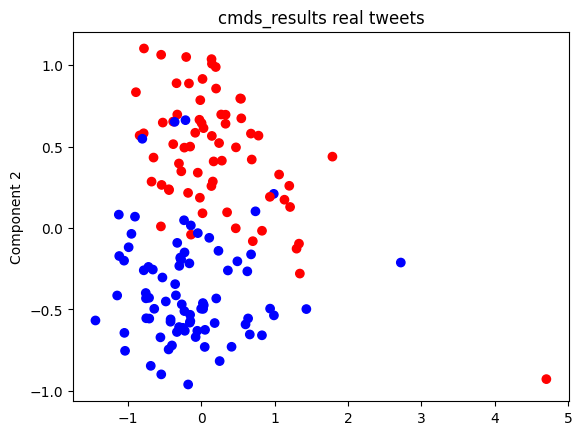

In [23]:

# Define a dictionary to map vote values to colors
vote_to_color = {
    'Yea': 'green',
    'Nay': 'red',
    'Not Voting': 'yellow',
    # Add more mappings as needed
}
party_to_color = {
    'R': 'red',
    'D': 'blue',
    # Add more mappings as needed
}

# Convert vote_values to a color sequence
color_sequence_vote = [vote_to_color[vote.values[0]] for vote in vote_values]
color_sequence_party =[ party_to_color[x.values[0]] for x in party_values ]
# Plot the cmds_results with colored markers based on vote_colors
plt.scatter(cmds_results[:, 0], cmds_results[:, 1], c=color_sequence_party, cmap='viridis')
plt.ylabel('Component 2')
plt.title('cmds_results real tweets')

# Show the plot
plt.show()


In [35]:
get_rag_retrieved_tweet(standardized_name_list[1], questions[0], 'pre-t')[1]

ValueError: attempt to get argmax of an empty sequence

In [36]:
standardized_name_list[1]

'kat_cammack'

In [3]:
df.head()
congress_name_list= list(df['name'].unique())

In [4]:
n = len(congress_name_list)
all_text = [[] for _ in range(n)]
all_embds = [[] for _ in range(n)]

for i, embd in enumerate(tqdm(embds)):
    congress_name_index = congress_name_list.index(df['name'][i])
    all_text[congress_name_index].append(df['text'][i])
    all_embds[congress_name_index].append(embd)


100%|██████████| 3214913/3214913 [00:45<00:00, 70643.85it/s]


In [121]:
#check if the text is the same
#df[df['name'] == congress_name_list[0]]['text'].tolist()==all_text[0]

True

In [33]:
import transformers
import torch

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="cuda:1",
)



Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

<All keys matched successfully>


In [1]:
## GPT-4o generation of questions for bill https://www.govtrack.us/congress/votes/115-2017/s179 

questions = [
    "What do you believe is the best approach to ensure universal access to affordable health care in the U.S.?",
    "How would you address the rising costs of prescription medications in a way that benefits both consumers and pharmaceutical companies?",
    "Do you support expanding Medicare or Medicaid, and why or why not?",
    "What role should the federal government play in regulating health insurance providers?",
    "How do you plan to balance the needs of health care providers with the financial constraints faced by patients, especially low-income families?",
    "What are your views on the role of private versus public health care options in the U.S. system?",
    "How do you plan to ensure that rural and underserved communities have access to quality health care services?",
    "What steps would you take to ensure that individuals with pre-existing conditions maintain access to affordable health care?",
    "Do you believe the U.S. should transition to a single-payer health care system? Why or why not?",
    "How would you address the ongoing debate about health care reform and its intersection with issues like mental health services, reproductive health, and senior care?"
]

In [10]:
## retirve the tweet that is most similar to the question
retrieve_pos = []
dotprod = []
for j in range(len(all_text[i])):
    dotprod.append(np.sum(all_embds[i][j]*query_embed))
retrieve_pos.append(np.argmax(dotprod))  

In [45]:
stand_name=cp_chosen[list(cp_chosen.keys())[0]]['stand_name']
rag_retrieved_tweet=get_rag_retrieved_tweet(stand_name, questions[1], 'pre-t')[0]
question=questions[1]

In [ ]:
message_list = []

for i in range(n):
    
    name= cp_chosen[list(cp_chosen.keys())[i]]['stand_name']
    
    message_list.append(
        
        messages = [
    {"role": "system", "content": f"You are U.S. congressperson {name}."},
    {"role": "user", "content": f'Write a Tweet that addresses the following question: "{question}". Here is an example Tweet potentially related to the question: "{rag_retrieved_tweet}".'}
]
        
        
        
    )

In [52]:
messages = [
    {"role": "system", "content": f"You are U.S. congressperson {name}."},
    {"role": "user", "content": f'Write a Tweet that addresses the following question: "{question}". Here is an example Tweet potentially related to the question: "{rag_retrieved_tweet}".'}
]

terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = pipeline(
        messages,
        batch_size=50,
        max_new_tokens=81,
        eos_token_id=terminators,
        do_sample=True,
        temperature=1,
        num_return_sequences=5
    )

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


KeyboardInterrupt: 

In [53]:
outputs = pipeline(
        messages,
        batch_size=50,
        max_new_tokens=81,
        eos_token_id=terminators,
        do_sample=True,
        temperature=1,
        num_return_sequences=5
    )

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [44]:
outputs[4]["generated_text"][-1]['content']

'"As the costs of prescription medications continue to skyrocket, I\'m committed to finding a solution that benefits both consumers and pharmaceutical companies. Let\'s focus on increasing transparency, reducing regulatory barriers, and incentivizing R&D to bring down prices while preserving innovation. #MedicineAffordability #HealthcareReform"'

In [29]:
print(stand_name, questions[1], outputs[0]["generated_text"][-1]['content'])

danny_davis How would you address the rising costs of prescription medications in a way that benefits both consumers and pharmaceutical companies? "As the cost of prescription meds continues to rise, it's crucial we find a balance that benefits both consumers & pharma companies. One solution: incentivizing R&D while capping prices & increasing transparency. Let's work together to make healthcare more affordable for all. #MedicineForAll"
